<a href="https://colab.research.google.com/github/amrios80/linear-regression-tutorial/blob/master/aptos/aptos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

MINE-4101: Applied Data Science  
Univerisdad de los Andes  

**Contexto de Negocio:** La empresa Inmobiliaria Metro Cuadrado domicialada en la ciudad de Bogota - Colombia, quiere brindar a sus clientes una herramienta que les permita estimar el valor de un apartamento de acuerdo a sus caracteristicas fisicas y de ubicacion. El valor estimado debe ser lo mas cercano posible a la realidad para evitar labores de peritaje en el proceso de compra.

**Identificacion de la solución:** La necesidad de negocio planteada puede solucionarse utilizando un algoritmo de manchine learning como regresion lineal dado que se requiere predicir un valor numerico (precio de venta) y contamos con informacion de mercado que nos indica el valor real de los apartamentos de acuerdo a sus caracteristicas.

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Carga de los datos

In [3]:
dataset_url="https://github.com/amrios80/linear-regression-tutorial/raw/refs/heads/master/crabs/data/apartamentos.zip"
apto_df = pd.read_csv(dataset_url, compression="zip")

## 2. Entendimiento y limpieza de los datos

Dado el contexto de negocio e interpretacion de los datos, se identifica que la variable PRECIO_VENTA es la variable objetivo del modelo de regresion lineal a desarrollar y se utilizaran todas las variables numericas a excepcion de XXXXXX dado que se consideran no relevantes para el ejercicio, en cuanto a las variables categoricas consideraremos dentro del analisis SECTOR y ANTIGUEDAD previo conversion a valores numericos utilizando la tecnica de label encoding.

### 2.1 Entendimiento de los datos

In [5]:
apto_df.shape

(43013, 46)

In [6]:
apto_df.dtypes

,0
_id,object
codigo,object
tipo_propiedad,object
tipo_operacion,object
precio_venta,float64
area,float64
habitaciones,float64
banos,float64
administracion,float64
parqueaderos,float64


In [8]:
apto_df.sample(3)

,_id,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,estado,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
14435,66d86cdaceda690e8550bfc3,488-M4791794,APARTAMENTO,ARRIENDO,NaN,122.00,2.00,2.00,NaN,2.00,CHICO,6.00,REMODELADO,4.68,-74.05,NaN,"arriendo este magnifico apartamento exterior,...",metrocuadrado.com,2024-08-09 09:04:23.563,2024-07-04 13:40:07.222,NaN,[],USADO,ADEINCO SAS,4900000.00,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,False,CHAPINERO,S.C. CHICO NORTE III SECTOR,Calle 100 - Marketmedios,723.46,0,PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...,975.66,0
6203,66d86c99ceda690e85509f9b,847-M4685752,APARTAMENTO,VENTA,3800000000.00,650.00,5.00,3.00,1650000.00,2.00,CHICO,6.00,MAS DE 20 ANOS,4.68,-74.05,NaN,ofrecemos en venta este espacioso apartamento ...,metrocuadrado.com,2024-08-02 19:16:37.714,2024-07-04 05:38:24.790,NaN,[],USADO,PADS,NaN,1.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,False,CHAPINERO,S.C. CHICO NORTE,Calle 100 - Marketmedios,617.55,0,PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...,675.32,0
8785,66d86ca9ceda690e8550a9b1,2377-M4476189,APARTAMENTO,VENTA,260000000.00,49.00,2.00,1.00,NaN,0.00,LA SOLEDAD,3.00,ENTRE 10 Y 20 ANOS,4.64,-74.07,NaN,"hermoso apartamento en palermo, cra 16 no 48-7...",metrocuadrado.com,2024-07-04 08:38:04.680,2024-07-04 08:38:04.680,NaN,NaN,USADO,CIUDAD INMOBILIARIA LTDA,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,False,TEUSAQUILLO,QUESADA,Marly,274.45,1,PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) EN...,1345.01,0


In [ ]:
apto_df=apto_df[apto_df["tipo_operacion"]=="VENTA"]
#apto_df["tipo_operacion"].value_counts()
#apto_df.sample(5)

In [ ]:
def print_max(df, target_var):
    print("max")
    return df.sort_values(by=target_var, ascending=False).head(10)
def  print_min(df, target_var):
    print("min")
    return df.sort_values(by=target_var, ascending=True).head(10)

print_max(apto_df, "precio_venta")

print_min(apto_df, "precio_venta")



max
min


,_id,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,estado,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
37315,66d86e3eceda690e85511923,3147-M4865828,APARTAMENTO,VENTA,1000000.00,125.00,3.00,3.00,1750000.00,2.00,SANTA BARBARA,6.00,ENTRE 0 Y 5 ANOS,4.69,-74.05,NaN,vendo bonito apartamento en chico navarra. ubi...,metrocuadrado.com,2024-08-13 12:43:13.227,2024-08-13 12:43:13.227,NaN,NaN,USADO,M Y M NEGOCIOS SAS,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,False,USAQUEN,SANTA BIBIANA,Calle 106,873.44,0,PARQUE METROPOLITANO EL COUNTRY,1800.78,0
37696,66d86e46ceda690e85511aa0,898-M4548497,APARTAMENTO,VENTA,1000000.00,170.00,3.00,3.00,785000.00,2.00,SANTA BARBARA,6.00,MAS DE 20 ANOS,4.69,-74.04,NaN,"hermoso apartamento , magnifica vista a la mon...",metrocuadrado.com,2024-08-13 13:14:57.364,2024-08-13 13:14:57.364,NaN,NaN,USADO,SOLUCION INMOBILIARIA FINCA RAIZ EU,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,False,USAQUEN,SANTA BARBARA CENTRAL III SECTOR,Pepe Sierra,2106.14,0,PARQUE METROPOLITANO EL COUNTRY,1108.55,0
37131,66d86e3bceda690e8551186b,MC3204619,APARTAMENTO,VENTA,1100000.00,147.00,2.00,3.00,1200000.00,2.00,CHICO,6.00,REMODELADO,4.67,-74.05,NaN,"remodelado, muy bien ubicado , cerca a restaur...",metrocuadrado.com,2024-08-13 12:28:12.023,2024-08-13 12:28:12.023,NaN,NaN,USADO,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,False,CHAPINERO,S.C. CHICO NORTE,Virrey,1154.96,0,PARQUE VECINAL URBANIZACIÓN LA CABRERA,538.49,0
42544,66d86eb4ceda690e85512d90,MC2406917,APARTAMENTO,VENTA,1100000.00,160.00,3.00,2.00,688000.00,1.00,CENTRO INTERNACIONAL,4.00,MAS DE 20 ANOS,4.61,-74.07,NaN,"apartamento en edificio independencia, barrio ...",metrocuadrado.com,2024-08-23 01:01:11.666,2024-08-23 01:01:11.666,NaN,NaN,USADO,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,False,SANTA FE,SAN DIEGO,San Diego,365.20,1,PARQUE METROPOLITANO INDEPENDENCIA BICENTENARIO,136.05,1
3234,66d86c8aceda690e85509402,3204-M4307528,APARTAMENTO,VENTA,1100000.00,154.00,3.00,3.00,1000000.00,2.00,CHICO,6.00,MAS DE 20 ANOS,4.65,-74.05,NaN,"magnifico apartamento ,muy buen edificio ,piso...",metrocuadrado.com,2024-08-23 00:12:29.629,2024-07-04 02:24:26.340,NaN,[],USADO,MARCELA CORTES ARBOLEDA,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,False,CHAPINERO,S.C. BELLAVISTA,Flores – Areandina,1157.08,0,PARQUE ZONAL GUSTAVO URIBE BOTERO,284.83,1
31231,66d86dc6ceda690e8551015f,2536-M2244887,APARTAMENTO,VENTA,1100000.00,175.00,3.00,3.00,520000.00,2.00,METROPOLIS,4.00,ENTRE 0 Y 5 ANOS,4.67,-74.09,NaN,se vende hermoso apartamento duplex remodela...,metrocuadrado.com,2024-08-03 02:01:11.054,2024-08-03 02:01:11.054,NaN,NaN,USADO,GLOBAL PENTHOUSE,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,False,BARRIOS UNIDOS,S.C. JOSE JOAQUIN VARGAS,AV. Chile,1206.14,0,PARQUE METROPOLITANO PARQUE DE LOS NIÑOS,766.43,0
39942,66d86e78ceda690e85512366,2699-M2475261,APARTAMENTO,VENTA,1100000.00,220.00,3.00,5.00,718000.00,2.00,SANTA BARBARA,6.00,ENTRE 10 Y 20 ANOS,4.69,-74.05,NaN,"duplex , iluminado, clasico en excelente estad...",metrocuadrado.com,2024-08-13 18:37:55.032,2024-08-13 18:37:55.032,NaN,NaN,USADO,CONEXION INMOBILIARIA,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,False,USAQUEN,SAN PATRICIO,Calle 106,169.63,1,PARQUE ZONAL CANAL CORDOBA,1472.63,0
31226,66d86dc6ceda690e8551015a,2536-M2777179,APARTAMENTO,VENTA,1100000.00,140.00,4.00,4.00,350000.00,2.00,METROPOLIS,4.00,ENTRE 0 Y 5 ANOS,4.67,-74.08,NaN,"se vende penthouse sala comedor, dos alcoba...",metrocuadrado.com,2024-08

In [ ]:
apto_df["area"].describe()

,area
count,27270.00
mean,142.28
std,235.13
min,0.00
25%,69.00
50%,109.47
75%,180.00
max,19621.00


In [ ]:
apto_backup=apto_df.copy()

In [ ]:
apto_df=apto_backup.copy()

In [ ]:
def cut_outliers_from_df(df0 , field="price", iqr_pct=0.25):
  df=df0.copy()
  print(f"Statistics for {field}:")
  print("before:")
  print(df[field].describe( percentiles=[0.25, 0.50, 0.75, 0.95]))
  if pd.api.types.is_numeric_dtype(df[field]):
     q1 = df[field].quantile(0.25)
     q3 = df[field].quantile(0.75)
     iqr = q3 - q1
     lower_bound = q1 - (iqr_pct * iqr)
     upper_bound = q3 + (iqr_pct * iqr)
     df=df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]
     print(f"after (iqr):")
     print(df[field].describe( percentiles=[0.25, 0.50, 0.75, 0.95]))
  return df

In [ ]:
df2=cut_outliers_from_df(apto_df, field="area")
df2["area"].describe()
apto_df=df2

Statistics for area:
before:
count   27270.00
mean      142.28
std       235.13
min         0.00
25%        69.00
50%       109.47
75%       180.00
95%       325.33
max     19621.00
Name: area, dtype: float64
after (iqr):
count   20882.00
mean      105.05
std        44.82
min        41.25
25%        67.00
50%        95.00
75%       138.00
95%       190.00
max       207.74
Name: area, dtype: float64


In [ ]:
df2=cut_outliers_from_df(apto_df, field="precio_venta", iqr_pct=0.1)
df2["precio_venta"].describe()
apto_df=df2

Statistics for precio_venta:
before:
count           20882.00
mean       1425712576.85
std       32934079329.50
min           1000000.00
25%         390000000.00
50%         600000000.00
75%         930000000.00
95%        1600000000.00
max     3300000000000.00
Name: precio_venta, dtype: float64
after (iqr):
count       12477.00
mean    612187315.35
std     180546898.56
min     336000000.00
25%     456000000.00
50%     587005122.00
75%     750000000.00
95%     935200000.00
max     984000000.00
Name: precio_venta, dtype: float64


In [ ]:
df2=cut_outliers_from_df(apto_df, field="administracion", iqr_pct=1)
apto_df=df2

Statistics for administracion:
before:
count        11462.00
mean       2808892.24
std       39208253.35
min              1.00
25%         390000.00
50%         530000.00
75%         750000.00
95%        1115000.00
max     1400000000.00
Name: administracion, dtype: float64
after (iqr):
count     10823.00
mean     553297.85
std      221689.01
min       30000.00
25%      384100.00
50%      513000.00
75%      708900.00
95%      970000.00
max     1110000.00
Name: administracion, dtype: float64


In [ ]:
numeric_vars = ["area", "habitaciones", "banos", "administracion", "parqueaderos", "estrato", "jacuzzi","piso","closets", "chimenea", "permite_mascotas","gimnasio", "ascensor","conjunto_cerrado","piscina","salon_comunal","terraza","vigilancia","distancia_estacion_tm_m","distancia_parque_m", "is_cerca_parque"]
categories=["tipo_propiedad", "sector", "antiguedad", "estado","compañia", "localidad", "barrio", "estacion_tm_cercana", "parque_cercano"]
categories=[]
print(apto_df.columns)

target_var="precio_venta"
features=numeric_vars + categories



Index(['_id', 'codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos',
       'sector', 'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')


In [ ]:
def get_df(df, target_var="target", numeric_vars=[], category_vars=[]):
  df = df.copy()
  label_encoder = LabelEncoder()
  for col in category_vars:
      df[col] = label_encoder.fit_transform(df[col].astype(str))
  # Define features and target
  #X = df.drop(columns=target_var)
  #y = df[target_var]
  df=df[ numeric_vars + category_vars+ [target_var]]
  return df

df = get_df(apto_df,"precio_venta" ,numeric_vars, categories )
df.to_csv("data.csv", index=False, sep=";" )
#df.sample(3)

In [ ]:
# Encuentra el porcentaje de nulos por columna
df[[target_var]+features].isnull().sum() / df.shape[0]

,0
precio_venta,0.00
area,0.00
habitaciones,0.00
banos,0.00
administracion,0.00
parqueaderos,0.00
estrato,0.00
jacuzzi,0.00
piso,1.00
closets,1.00


In [ ]:
df_original = df.copy()

In [ ]:
df=df_original.copy()
if "piso" in df.columns:
    df = df.drop(columns=['piso'])
    if "piso" in features:
        features.remove("piso")
if "closets" in df.columns:
    df = df.drop(columns=['closets'])
    if "closets" in features:
        features.remove("closets")

#features=['area', 'habitaciones', 'banos', 'administracion', 'parqueaderos',
#       'estrato', 'jacuzzi', 'chimenea', 'permite_mascotas', 'gimnasio',
#       'ascensor', 'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza',
#       'vigilancia', 'distancia_estacion_tm_m', 'distancia_parque_m',
#       'is_cerca_parque', 'tipo_propiedad', 'sector', 'antiguedad', 'estado',
#       'compañia', 'localidad', 'barrio', 'estacion_tm_cercana',
#       'parque_cercano']


# Quita los valores nulos
df = df.dropna(subset=[target_var]+features)
df_clean = df.dropna()
df= df_clean

# Quita los precios en cero.
#df=df[df[target_var]>0]
df.shape

(10822, 20)

In [ ]:
df[target_var].describe()

,precio_venta
count,10822.00
mean,602676843.34
std,176669670.89
min,336000000.00
25%,450000000.00
50%,576056000.00
75%,745000000.00
max,984000000.00


In [ ]:

df.sort_values(by=target_var, ascending=False).head(100)

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,precio_venta
40726,144.00,3.00,3.00,688000.00,2.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,372.21,407.39,1,984000000.00
8022,205.00,4.00,4.00,980000.00,2.00,5.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,694.61,1231.33,0,983940074.00
20410,180.00,3.00,4.00,650000.00,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,408.70,1072.54,0,982000000.00
25971,90.28,2.00,3.00,813718.00,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1273.61,703.83,0,980856000.00
4374,146.00,2.00,4.00,1000000.00,2.00,6.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,346.64,1399.81,0,980000001.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25433,128.00,3.00,3.00,675000.00,2.00,5.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,298.39,387.00,1,980000000.00
1920,102.00,3.00,2.00,936700.00,2.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1064.60,806.58,0,980000000.00
22404,144.00,3.00,3.00,950000.00,2.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1406.99,1163.96,0,980000000.00
30034,172.00,3.00,3.00,870000.00,2.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,421.60,314.08,1,980000000.00


In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)


df=cut_outliers_from_df(df, field=target_var)

Statistics for precio_venta:
before:
count       10822.00
mean    602676843.34
std     176669670.89
min     336000000.00
25%     450000000.00
50%     576056000.00
75%     745000000.00
95%     923000000.00
max     984000000.00
Name: precio_venta, dtype: float64
after (iqr):
count        8225.00
mean    568574165.06
std     122869012.25
min     377000000.00
25%     460000000.00
50%     550000000.00
75%     670000000.00
95%     780000000.00
max     815402051.00
Name: precio_venta, dtype: float64


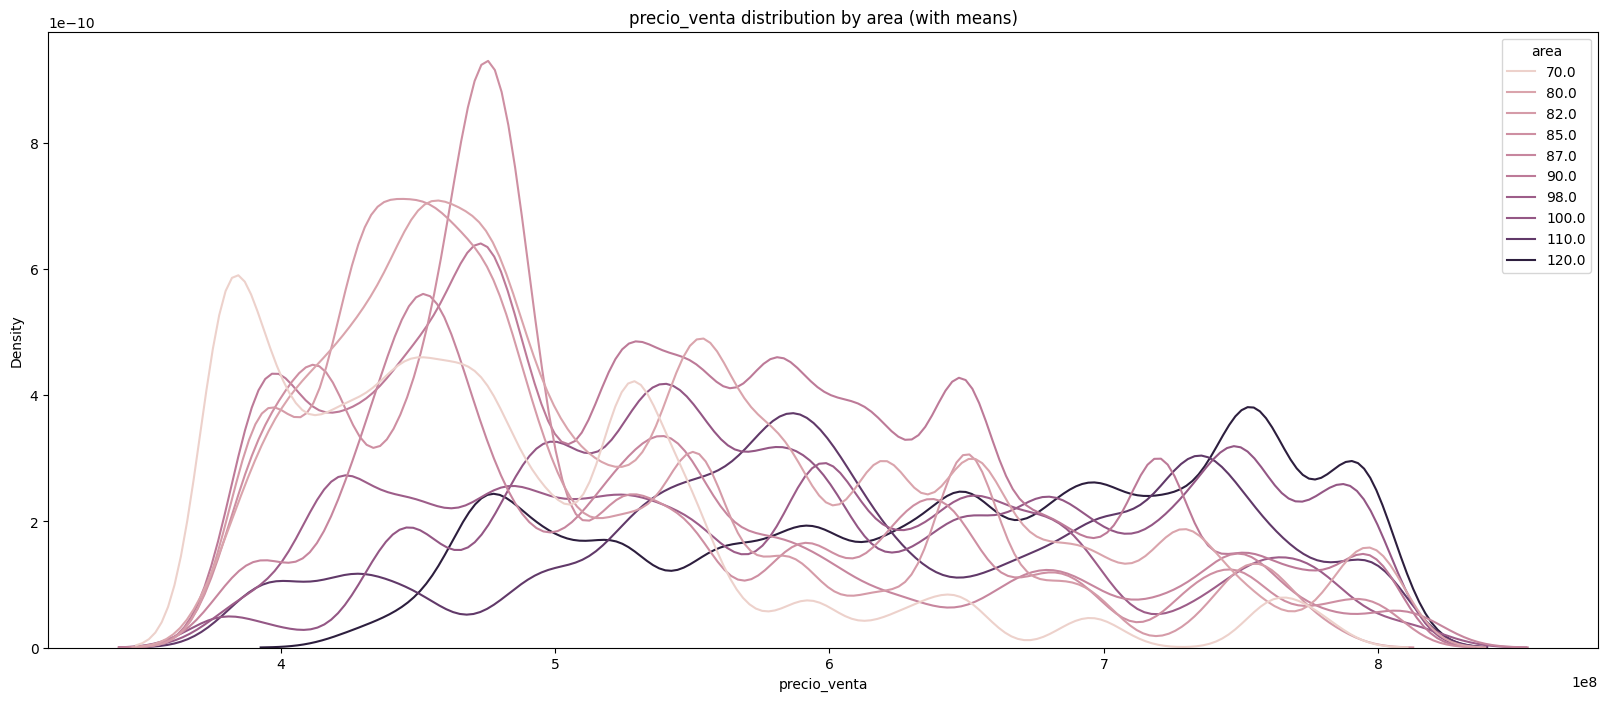

In [ ]:
def line_graph(df, field="brand", x_var="price"):
  density_var=field

  top_brands = df[field].value_counts().head(10).index.tolist()
  marcas_frec_cumsum=df[field].value_counts(normalize=True).cumsum()

  q1 = df[x_var].quantile(0.25)
  q2 = df[x_var].quantile(0.50)
  q3 = df[x_var].quantile(0.75)
  iqr = q3 - q1

  fig, ax = plt.subplots(1, 1, figsize=(20, 8))
  sns.kdeplot(
      data=df.loc[df[x_var] <= (q3 + 1.5 * iqr)].loc[df[field].isin( top_brands )],
      x=x_var,
      hue=field,
      bw_adjust=.3,
      ax=ax
  )
  for (brand, color) in zip( marcas_frec_cumsum , ["steelblue", "orange", "green"]):
      ax.axvline(df.loc[df[ x_var ] <= (q3 + 1.5 * iqr)].loc[df[ density_var] == brand, density_var].mean(), color=color, linestyle="dashed", linewidth=2, ymax=0.2)
  plt.title(f"{x_var} distribution by {density_var} (with means)")
  if "YEAR" in x_var :
    #plt.xscale("log")
    plt.xlim(1950, 2025)  # Set x-axis limits

  plt.show()

line_graph(df, field="area", x_var="precio_venta")

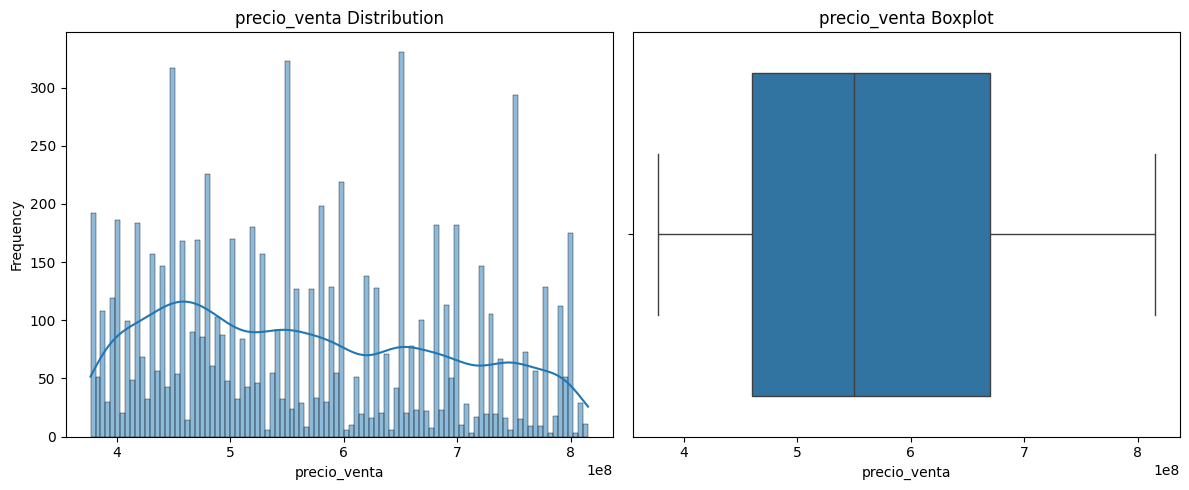

In [ ]:
#Funciones para revision de las variables.
def histogram(df , field="price"):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  sns.histplot(df[field], bins=100, kde=True)
  plt.title(f'{field} Distribution')
  plt.xlabel(field)
  plt.ylabel('Frequency')
  plt.subplot(1, 2, 2)
  sns.boxplot(x=df[field])
  plt.title(f'{field} Boxplot')
  plt.xlabel(field)
  plt.tight_layout()
  plt.show()

histogram(df, field="precio_venta")

In [ ]:
#df[[target_var]+features].isnull().sum() / df.shape[0]

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

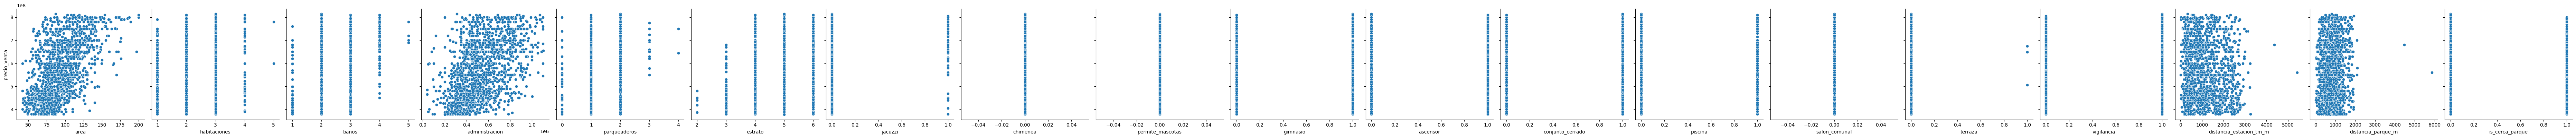

In [ ]:
sns.pairplot(df.sample(frac=0.2), height=4, y_vars=target_var, x_vars=features, kind="scatter")

In [ ]:
to_drop=["jacuzzi", "chimenea", "permite_mascotas", "gimnasio","ascensor", "conjunto_cerrado", "piscina", "salon_comunal",
         "terraza", "vigilancia", "distancia_estacion_tm_m", "distancia_parque_m","is_cerca_parque",
         "habitaciones","parqueaderos","estrato","banos"
         ]
df=df.drop(columns=to_drop, errors='ignore', axis=1)
features=list(set(features)-set(to_drop))

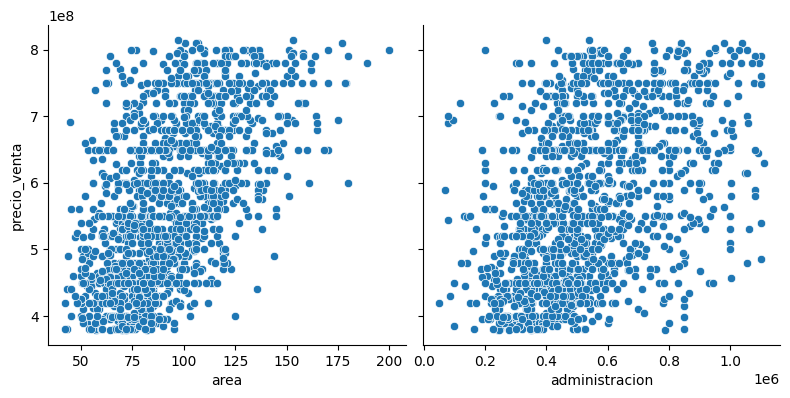

In [ ]:
sns.pairplot(df.sample(frac=0.2), height=4, y_vars=target_var, x_vars=features, kind="scatter")

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

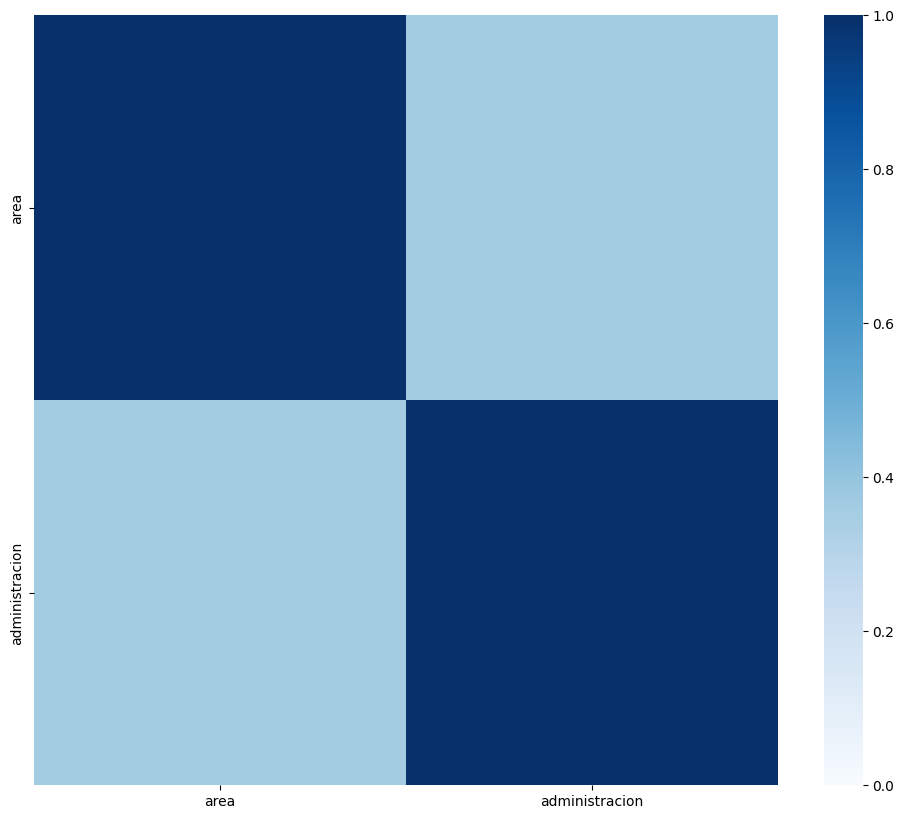

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap( df[features].corr(), cmap="Blues", vmin=0, vmax=1)

Un buen punto de corte (empírico) para decidir si descartar una variable debido a su alta correlación con otra es ~$|0.8|$. Este análisis se retomará más adelante durante la comprobación de supuestos.

## 3. Prepración de datos

Por lo general, en el Machine Learning supervisado también suele ser común verificar si existen registros duplicados, particularmente para el conjunto de variables de entrada y variable objetivo. Mantener registros duplicados, aún sin considerarse un problema de calidad de los datos, ocasionará que durante el proceso de aprendizaje el algoritmo otorgue de forma errónea un peso mayor a estos registros duplicados.

In [ ]:
total_rows = df.shape[0]
total_rows

7116

In [ ]:
df.loc[ df.duplicated(subset=features, keep=False)].head(3)

,area,administracion,precio_venta
17,86.00,666700.00,423300000.00
46,70.00,624000.00,527400000.00
50,95.00,576000.00,508067531.00


In [ ]:
duplicated_rows = df.loc[df.duplicated(subset=features, keep=False)].shape[0]
duplicated_rows

1654

In [ ]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 23.2434%


In [ ]:
df.loc[df.duplicated(subset=features+[target_var], keep=False)]

,area,administracion,precio_venta
17,86.00,666700.00,423300000.00
46,70.00,624000.00,527400000.00
50,95.00,576000.00,508067531.00
69,68.00,566000.00,459200000.00
74,91.00,291500.00,499950000.00
...,...,...,...
42400,77.00,820000.00,385000000.00
42655,135.00,808000.00,580000000.00
42683,108.00,335000.00,380000000.00
42684,128.00,830000.00,720000000.00


In [ ]:
duplicated_rows = df.loc[df.duplicated(subset=features+[target_var], keep=False)].shape[0]
duplicated_rows

286

In [ ]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 4.0191%


Aquí hay dos escenarios a analizar:
1. Existe un ~5% de registros con variables de entrada duplicadas, incluso con variable objetivo diferente. Una cantidad no muy preocupante pero que, en términos generales, requeriría de un proceso complementario de limpieza de datos para evitar confundir al modelo al momento de aprender la función de estimación.
2. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el 3.8% registros duplicados adicionales. Para un porcentaje mayor esto representaría potencialmente otro problema obligando al algoritmo de optimización a enfocarse más en aquellos registros duplicados en lugar de ponderar todos los registros por igual.

In [ ]:
df.drop_duplicates(subset=features, inplace=True)
df.shape
#print(df.sample(3))
df.drop_duplicates(subset=features+[target_var], inplace=True)
df.shape
df.to_csv("data_clean.csv", index=False, sep=";" )

In [ ]:
print(features)
print(df.columns)
df.shape


['area', 'administracion']
Index(['area', 'administracion', 'precio_venta'], dtype='object')


(6163, 3)

## 4. Particionamiento del conjunto de datos en entrenamiento y prueba

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos previamente desconocidos.

Metodológicamente, una práctica común para validar esto es separando el conjunto de datos etiquetado en dos partes: entrenamiento y prueba. La proporción reservada para probar el modelo es definida por el analista, pero un valor común es 30%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(  df[features], df[target_var], test_size=0.3, random_state=1)

In [ ]:
X_train.shape, y_train.shape

((4314, 2), (4314,))

In [ ]:
X_test.shape, y_test.shape

((1849, 2), (1849,))

## 5. Entrenamiento de un primer modelo de regresión lineal

Se deice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target).

En Scikit-Learn existen varias formas de implementar el algoritmo de regresión lieal, pero dado que el objetivo de esta practica esta enfocado en el análisis del modelo resultante y no tanto del algoritmo o del proceso de entrenamiento, se utilizará la implementación más sencilla dada por la clase LinearRegression.

In [ ]:
regression = LinearRegression()

In [ ]:
regression.fit(X_train, y_train)

LinearRegression()

### 4.1. Interpretación de los coeficientes y del intercepto

Los coeficientes de la regresión brindan una intuición del impacto o la fuerza de una variable de entrada en la predicción/estimación de la variable objetivo.

In [ ]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

,columns,coef
0,area,2173972.07
1,administracion,175.06


In [ ]:
regression.intercept_

273788535.04643965

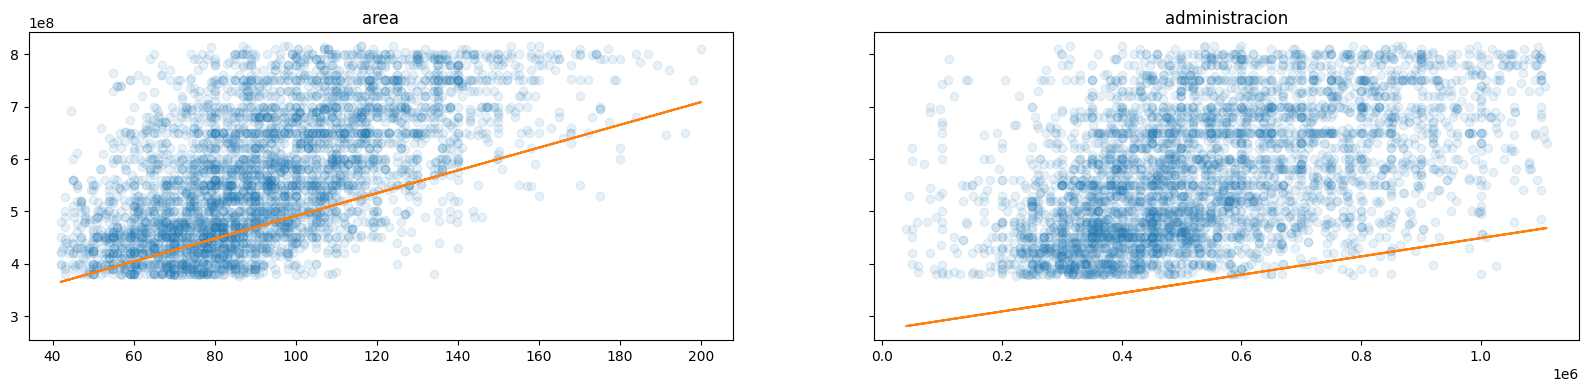

In [ ]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Recuerde que el modelo de regresión lineal para este caso particular está dado de la forma

$$ y = {\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3} + \beta_{4}x_{4} + \beta_{5}x_{5}} $$

siendo $\beta_{0}$ el intercepto (bias) y $\beta_{1}$, $\beta_{2}$, $\beta_{3}$, $\beta_{4}$ y $\beta_{5}$ los coeficientes o parámetros correspondientes a las variables de entrada en el mismo orden.

Tenga en cuenta que:
1) El signo del coeficiente representa la dirección de la relación entre la variable de entrada correspondiente y la variable objetivo. Signos positivos implican que si el valor de la variable de entada aumenta, el valor de la variable objetivo también aumentará, mientras que signos negativos indican que si el valor de la variable de entrada aumenta, el valor de la variable objetivo disminuirá.
2) El valor del coeficiente cuantifica la magnitud de la relación, implicando que un aumento o disminución (dependiendo del signo del coeficiente) en una unidad de la variable de entrada representará un cambio equivalente al valor del coeficiente en la variable objetivo, asumiendo que los valores de las demás variables de entrada permanezcan constantes.

**Ejemplo:**

Haciendo énfasis en `valence`, se sabe que cada cambio unitario en esta variable tendrá un impacto porcentual equivalente a ~11.4% en la variable objetivo, asumiendo que los valores de las demás variables permanecen constantes.

In [ ]:
# Dado que `x` se encuentra en el rango de 0 a 1, se simula un cambio de 0.1 múltiples veces para un mismo registro
# Siendo el incremento de apenas 1/10 de unidad, se espera un cambio en la estimación de la variable objetivo de ~0.57%

def check_prediction(df2, regression, features,proporcional_var):
  df=df2.copy()
  df = pd.concat([    df[features].iloc[0:1]] * 5).reset_index()
  df[ proporcional_var ] = df[ proporcional_var  ] + (df.index *10  )
  df["prediction"] = regression.predict(df[features])
  df["% change"] = df["prediction"].diff()
  return df

check_prediction(df, regression, features, "area")

,index,area,administracion,prediction,% change
0,2,54.00,305000.00,444575554.85,NaN
1,2,64.00,305000.00,466315275.56,21739720.71
2,2,74.00,305000.00,488054996.27,21739720.71
3,2,84.00,305000.00,509794716.99,21739720.71
4,2,94.00,305000.00,531534437.70,21739720.71


Aún cuando el cambio en la variable objetivo es el esperado, note que las variables de entrada no se encuentran en la misma escala, rangos o grados de magnitud. Debido a esto, las magnitudes o valores de los coeficientes no son directamente comparables entre sí, es decir, no es posible decir por ejemplo que `Diameter` tiene un impacto mayor que `Shell Weight` en la estimación de la edad de un cangrejo. Aunque si se puede decir que `Length` tiene un impacto negativo en la estimación.

Por otro lado, el intercepto puede ser útil para determinar un valor de base en la estimación, en este caso una edad mínima bajo el supuesto de que pudiera existir un cangrejo con todas sus variables de entrada iguales a cero.

### 4.2. Validación (evaluación) del modelo

La forma más básica para saber que tan bien se comporta el modelo es midiendo que tanto se alejan las estimaciones o predicciones del mismo respecto a la variable objetivo real. Esta medición se puede hacer tanto para el conjunto de datos de entrenamiento como para el de prueba.

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [ ]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 76171450.17175505
Test: 76031302.97754566


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

In [ ]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Tes t:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 93193455.3940145
Tes t: 93298893.41410469


**Análisis del error**

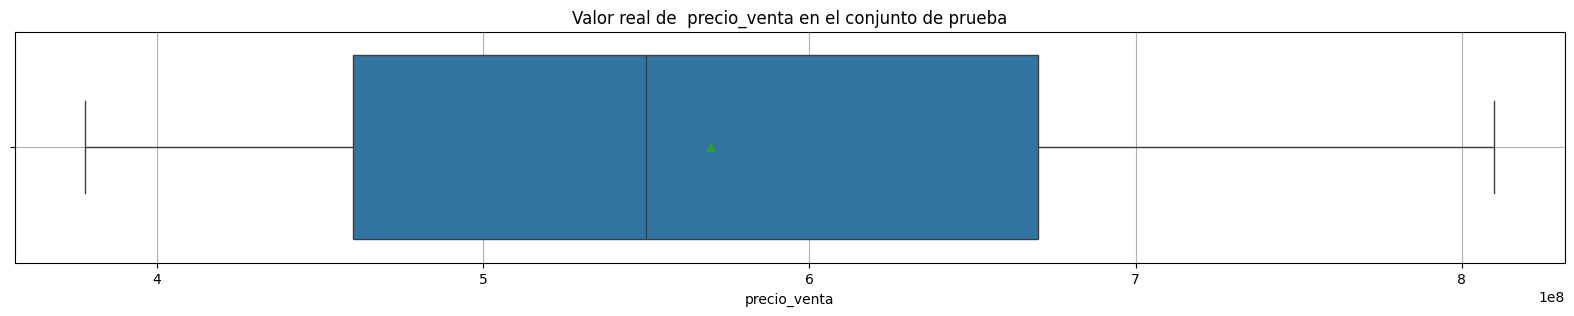

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title(f"Valor real de  {target_var} en el conjunto de prueba")
plt.grid()
plt.show()

In [ ]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

,precio_venta
count,1849.00
mean,569908186.65
std,124810574.93
min,378000000.00
25%,460000000.00
50%,550000000.00
75%,670000000.00
99%,800000000.00
max,810000000.00


Aún cuando `target_var` se mueve en el rango de x1 a x2 , la mayoría de sus posibles valores se encuentran entre x3 y x4. Tener esto claro es importante para determinar que tan grande o que tan bajo es el error promedio respecto a la variable objetivo.

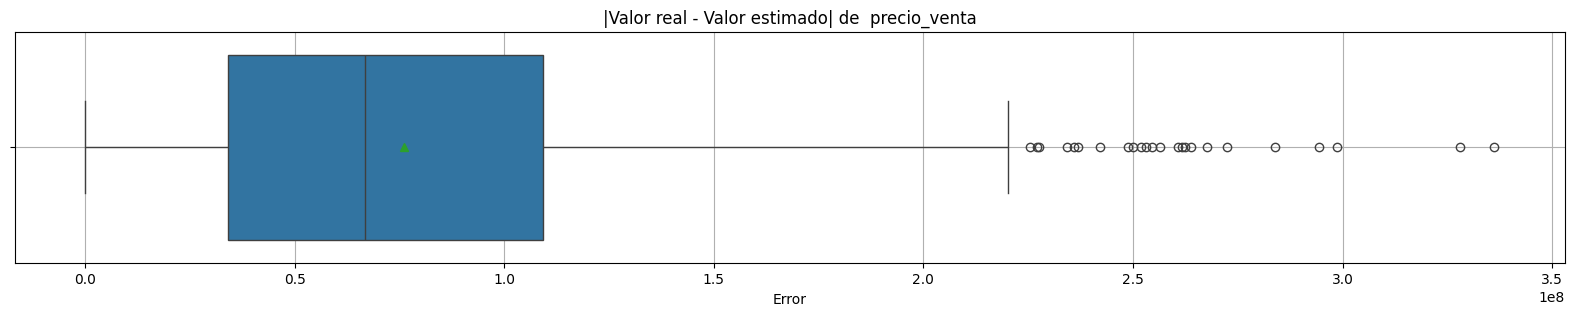

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title(f"|Valor real - Valor estimado| de  {target_var}")
plt.xlabel("Error")
plt.grid()
plt.show()

In [ ]:
abs(y_test-regression.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,precio_venta
count,1849.00
mean,76031302.98
std,54087953.28
min,28802.45
25%,33968878.79
50%,66814824.16
75%,109226096.01
95%,176350266.33
99%,236356410.96
max,336243003.25


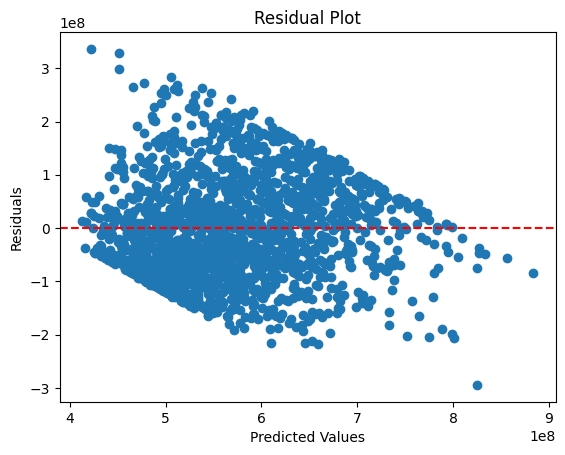

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
def check_residuals(y, y_pred):
  residuals = y - y_pred
  plt.scatter(y_pred, residuals)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Predicted Values')
  plt.ylabel('Residuals')
  plt.title('Residual Plot')
  plt.show()

check_residuals(y_test, regression.predict(X_test))

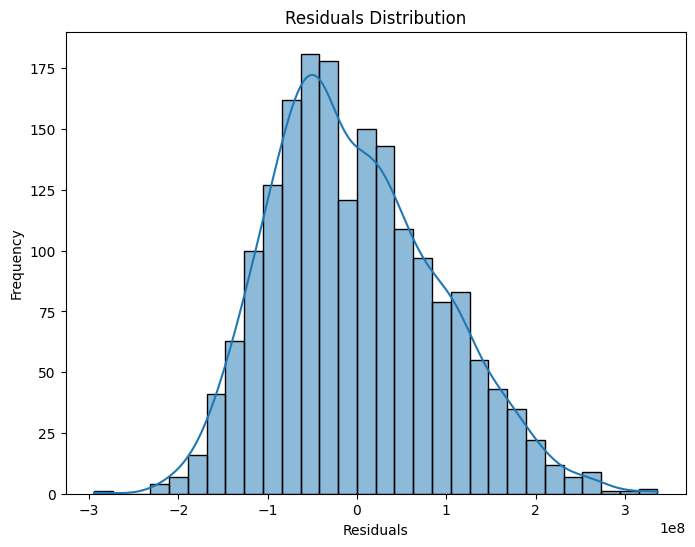

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y, y_pred):
  # Assuming residuals are calculated as y - y_pred
  residuals = y - y_pred

  # Plot histogram of residuals
  plt.figure(figsize=(8, 6))
  sns.histplot(residuals, kde=True)
  plt.title('Residuals Distribution')
  plt.xlabel('Residuals')
  plt.ylabel('Frequency')
  plt.show()

plot_residuals(y_test, regression.predict(X_test))

In [ ]:
from scipy.stats import shapiro

def shapiro_test(residuals):
  stat, p_value = shapiro(residuals)
  print('Shapiro-Wilk Test Statistic:', stat)
  print('p-value:', p_value)

  # Interpretation of p-value
  if p_value > 0.05:
      print('Residuals are normally distributed (fail to reject H0)')
  else:
      print('Residuals are not normally distributed (reject H0)')

shapiro_test(y_test - regression.predict(X_test))

Shapiro-Wilk Test Statistic: 0.9849482459322598
p-value: 5.055702570644094e-13
Residuals are not normally distributed (reject H0)


In [ ]:
from statsmodels.stats.stattools import jarque_bera

def jarque_bera_test(residuals):
  jb_stat, jb_p_value, skew, kurtosis = jarque_bera(residuals)
  print('Jarque-Bera Test Statistic:', jb_stat)
  print('p-value:', jb_p_value)

  if jb_p_value > 0.05:
      print('Residuals are normally distributed (fail to reject H0)')
  else:
      print('Residuals are not normally distributed (reject H0)')

  print('Skewness:', skew)
  print('Kurtosis:', kurtosis)

jarque_bera_test(y_test - regression.predict(X_test))

Jarque-Bera Test Statistic: 59.226988311720426
p-value: 1.3772820843650946e-13
Residuals are not normally distributed (reject H0)
Skewness: 0.43382529966663036
Kurtosis: 2.8737141927027894


In [ ]:
from scipy.stats import skew, kurtosis

def check_skewness_and_kurtosis(residuals):
  residuals_skewness = skew(residuals)
  residuals_kurtosis = kurtosis(residuals)

  print('Skewness:', residuals_skewness)
  print('Kurtosis:', residuals_kurtosis + 3)  # Adding 3 to get actual kurtosis

check_skewness_and_kurtosis(y_test - regression.predict(X_test))

Skewness: 0.43382529966663036
Kurtosis: 2.8737141927027894


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def get_r2_score( model, X, y):
# Assume X and y are your independent and dependent variables
#model = LinearRegression()
#model.fit(X, y)

  # Predict the values
  y_pred = model.predict(X)

  # Calculate R² score
  r2 = r2_score(y, y_pred)
  print("R² score:", r2)

get_r2_score(regression, X_test, y_test)

R² score: 0.44090557426226673


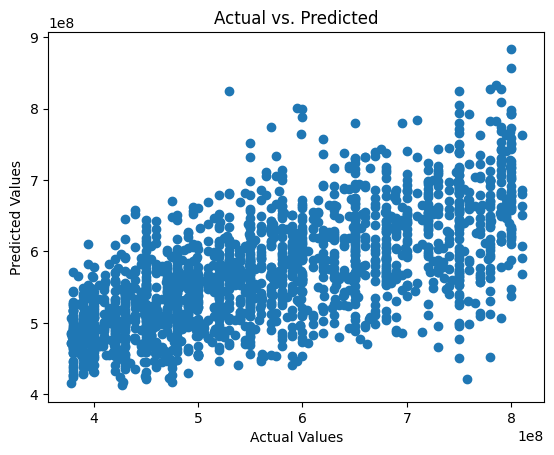

In [ ]:
def visualize_fit(y, y_pred):
  #plt.figure(figsize=(10, 6))
  #plt.scatter(y, y_pred
  plt.scatter(y, y_pred)
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted')
  plt.show()
visualize_fit(y_test, regression.predict(X_test))

Se podría decir que los resultados de este primer modelo NO son aceptables dado que:
1) Las métricas de error para el dataset de entrenamiento y prueba son .... XX se evidencian problemas de sobreajuste (overfitting).
2) Para el conjunto de prueba los valores de la variable objetivo están centrados en ...., mientras que el 75% de los errores de estimación del modelo se encuentran por debajo de ..., muy por debajo de una desviación estándar.

Un análisis del error más profundo implicaría, por ejemplo, identificar si el problema mayor se encuentra en la subestimación o la sobreestimación de la edad, así como ganar mayor intuición de cuales son los casos particulares en los que el modelo se equivoca más.

## 6. Entrenamiento de un segundo modelo aplicando normalización

Scikit-Learn permite integrar el proceso de normalización de features dentro de los procesos de entrenamiento y predicción de los modelos mediante el uso de Pipelines. Un Pipeline permite ejecutar de forma secuencial un conjunto de transformaciones de datos, selección de variables, entre otros, seguido del paso de entrenamiento o predicción.

La documentación oficial de Pipelines se puede encontrar aquí: https://scikit-learn.org/stable/modules/compose.html.

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

,columns,coef
0,area,57412270.43
1,administracion,36766465.72


In [ ]:
pipeline["model"].intercept_

573358793.592026

In [ ]:
y_train.mean(), y_test.mean()

(573358793.592026, 569908186.653867)

Aunque tras la transformación de las variables de entrada se pierde un poco de interpretabilidad de los datos, los coeficientes de la regresión ahora son directamente comparables, pudiendo decir que la variable de entrada que mayor tiene impacto en la variable objetivo es `Shell Weight`, muy por encima de `Diameter` que es la siguiente en magnitud. No se debe olvidar los coeficientes negativos, particularmente el correspondiente a la variable `Shucked Weight`, el cuál tiene una magnitud alta muy similar a `Shell Weight` en términos de valor absoluto.

La forma de entender el intercepto también cambia un poco. Al haber normalizado las variables de entrada, particularmente al haber centrado cada variable en cero removiendo su valor promedio, el valor del intercepto indica cual sería el valor de edad para un cangrejo promedio. Esto tiene sentido dado que corresponde con el valor promedio real (aproximado) de `Age` tanto para el conjunto de entrenamiento como para el de prueba.

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

MAE:
Train: 76171450.17175505
Test: 76031302.9775457

RMSE:
Train: 93193455.3940145
Test: 93298893.41410469


<span style="color: red;">Recuerde que la normalización de datos no siempre implica mejores métricas de error pero si garantiza un mejor proceso de entrenamiento y, dependiendo de la técnica de normalización utilizada, menor sensibilidad a valores atípicos.</span>

## 7. Validación de supuestos de la regresión

La construcción de un buen modelo de Machine Learning va más allá de solamente minimizar las métricas de error. El modelo de regresión lineal, desde una perspectiva clásica, debería además cumplir con los siguientes supuestos:

*Se volverán a revisar algunos aspectos que se habían descubierto en la etapa de entendimiento de los datos.*

### 7.1. Colinealidad

Es necesario que las variables utilizadas no tengan (o tengan muy baja) colinealidad (correlación).

<Axes: >

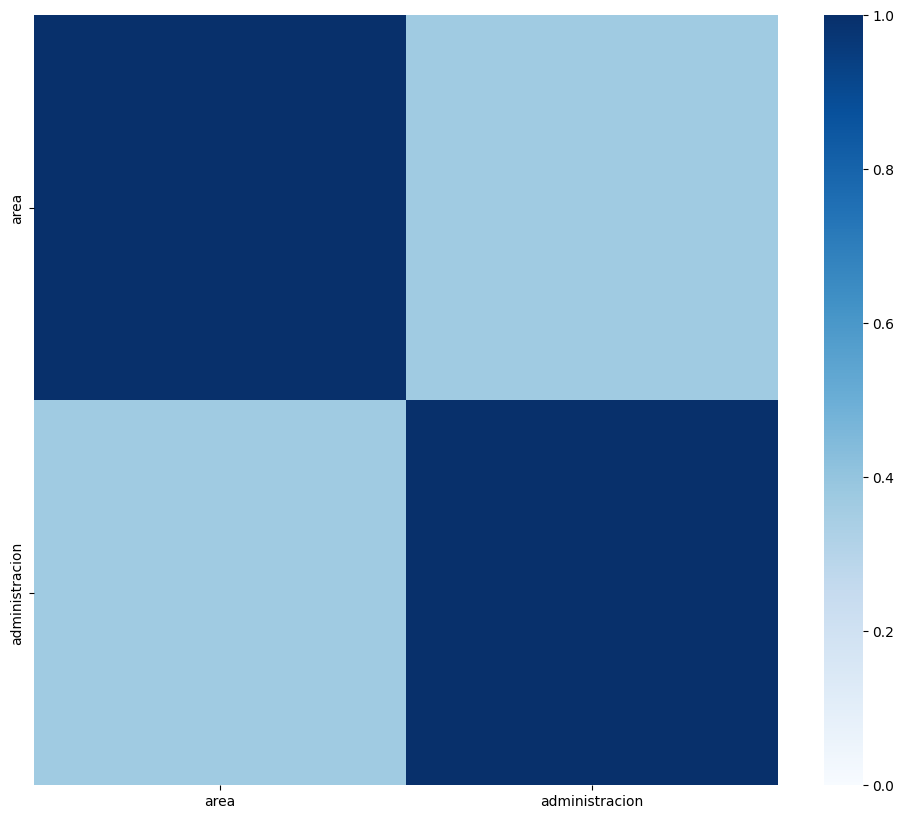

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [ ]:
X_train.corr()

,area,administracion
area,1.00,0.37
administracion,0.37,1.00


In [ ]:
def show_corr(df):
  # Step 1: Compute the correlation matrix
  corr_matrix = df.corr()

  # Step 2: Flatten the correlation matrix and keep track of the column pairs
  corr_pairs = (
      corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Only upper triangle (avoid duplicates)
      .stack()  # Convert to long-form
      .reset_index()  # Convert index to columns
  )

  corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

  # Step 3: Sort by absolute correlation value
  corr_pairs['Abs Correlation'] = corr_pairs['Correlation'].abs()
  sorted_corr = corr_pairs.sort_values(by='Abs Correlation', ascending=False)[:30]

  # Step 4: Display the top results
  print(sorted_corr)

show_corr(X_train)

  Column 1        Column 2  Correlation  Abs Correlation
0     area  administracion         0.37             0.37


En este caso particular, para evitar eliminar un importante número de variables, se opta por eliminar aquellas cuyo valor de correlación es superior al 90%.

In [ ]:
features2 = features

In [ ]:
X_train[features2].corr()

,area,administracion
area,1.00,0.37
administracion,0.37,1.00


In [ ]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
pd.DataFrame({"columns": features2, "coef": pipeline["model"].coef_})

,columns,coef
0,area,57412270.43
1,administracion,36766465.72


In [ ]:
pipeline["model"].intercept_

573358793.592026

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print("Test :", mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print("Test :", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 76171450.17175505
Test : 76031302.9775457

RMSE:
Train: 93193455.3940145
Test : 93298893.41410469


Hay algunos argumentos para decir que este nuevo modelo podría considerarse mejor que los anteriores:
1. Con el uso de menos variables de entrada (menor complejidad del modelo) se logra obtener unas métricas de error muy similares.
2. Se evidencia un mejor balance entre coeficientes de `Length` y `Height`, sin embargo, aún se observa coeficientes altos para `Shucked Weight` y `Shell Weight`. Idealmente, los coeficientes deberían estar lo más balanceados posible para evitar que el modelo sesgue sus estimaciones con base en solo unas pocas variables.

### 7.2. Linealidad

Es necesario que la relación entre cada variable de entrada y la varable objetivo sea lineal.

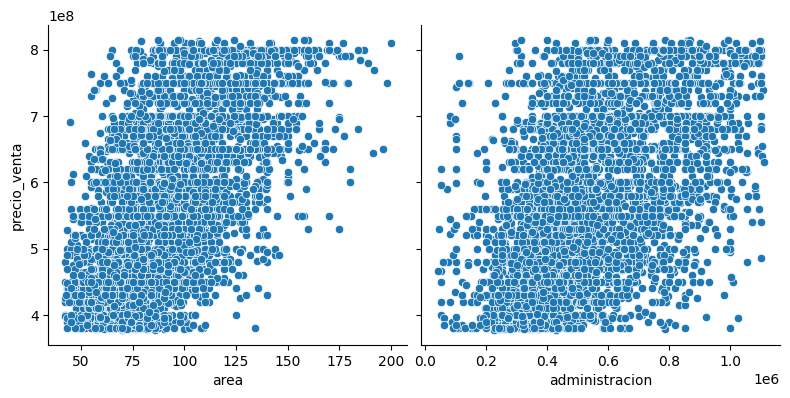

In [ ]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars=target_var , x_vars=features2, kind="scatter")

¿Es posible que x1 y x2 tengan una relación no lineal?

La forma más común de comprobarlo es agregar una transformación polinomial (PolynomialFeatures) de algún grado integrada al Pipeline. Tenga en cuenta que la transformación se aplicará a todas las variables de entrada y será labor del algoritmo de regresión determinar cuáles son las más relevantes para la estimación.

La documentación oficial de PolynomialFeatures se puede encontrar aquí: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html.

In [ ]:
pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
pd.DataFrame({"columns": pipeline["poly"].get_feature_names_out(), "coef": pipeline["model"].coef_})

,columns,coef
0,area,70475784.48
1,administracion,71915850.08
2,area^2,-7641308.60
3,area administracion,-10693065.04
4,administracion^2,-28603907.47


<span style="color: red;">Note que PolynomialFeatures no solo transforma las variables de entrada aplicando el grado deseado, también conserva las variables originales e incluye interacciones (multiplicación) entre estas. Esto hace que la interpretación de los coeficientes se vuelva más dificil.</span>

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 75966712.75695352
Test: 75660186.52719294

RMSE:
Train: 92904992.16927394
Test: 92811889.32394286


Nuevamente, aplicar este tipo de ajustes no asegura obtener un modelo con un menor error. Algunas razones por las cuáles el RMSE en el dataset de prueba aumento en lugar de disminuir pueden ser:

1. La existencia de algunos valores atípicos solamente en el dataset de test los cuales se agravaron al aplicar la transformación polinomial.
2. Tal como se videncia en las gráficas anteriores, si bien la relación con la variable objetivo puede no ser lineal, lo más probable es que tampoco sea polinómica sino más bien logaritmica.

### 7.3. Normalidad de los errores

Los errores deben tener una distribución normal.

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
errors = (pipeline.predict(X_train[features2])-y_train).values

Valores negativos indican subestimación mientras que valores positivos indican sobreestimación.

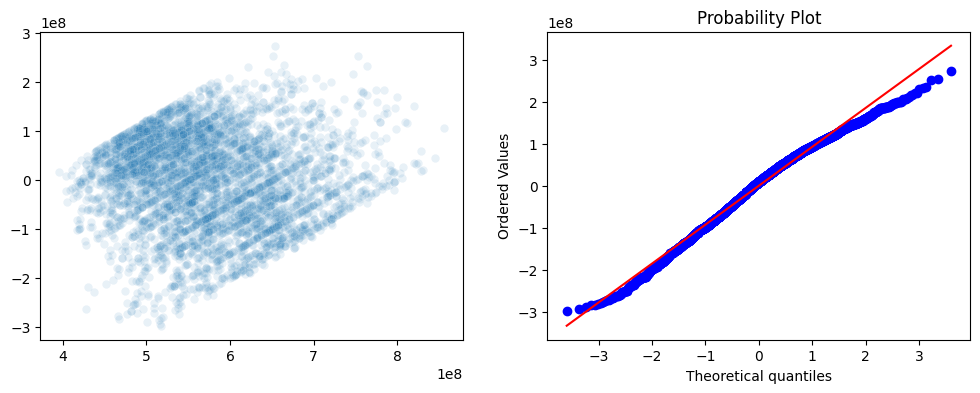

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[features2]), y=errors, alpha=0.1, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Una estrategia para mejorar este escenario es eliminar los registros cuyo valor de variable objetivo pueda considerarse un valor atípico.

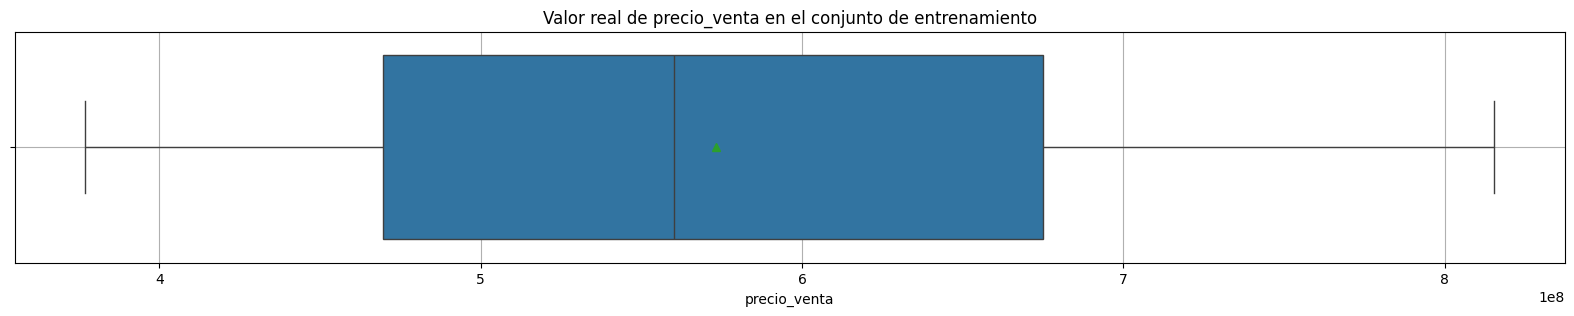

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_train, showmeans=True, orient="h")
plt.title(f"Valor real de {target_var} en el conjunto de entrenamiento")
plt.grid()
plt.show()

Para determinar los valores atípicos a remover se puede aplicar la regla $$outlier > Q3 + 1.5*IQR$$

In [ ]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3-q1
threshold = q3+1.5*iqr
threshold

983250000.0

In [ ]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [ ]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

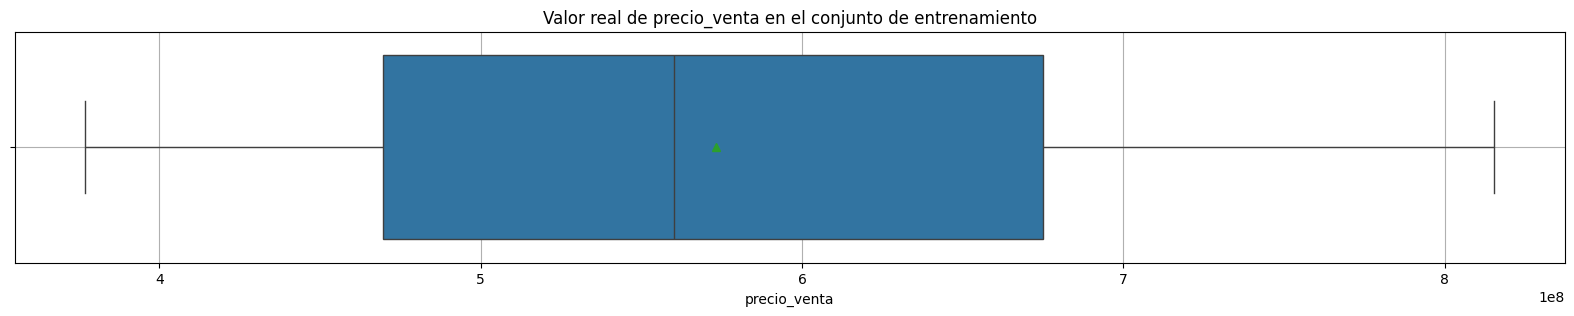

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_train, showmeans=True, orient="h")
plt.title(f"Valor real de {target_var} en el conjunto de entrenamiento")
plt.grid()
plt.show()

In [ ]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
pd.DataFrame({"columns": features2, "coef": pipeline["model"].coef_})

,columns,coef
0,area,57412270.43
1,administracion,36766465.72


In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 76171450.17175505
Test: 76031302.9775457

RMSE:
Train: 93193455.3940145
Test: 93298893.41410469


In [ ]:
errors = (pipeline.predict(X_train[features2])-y_train).values

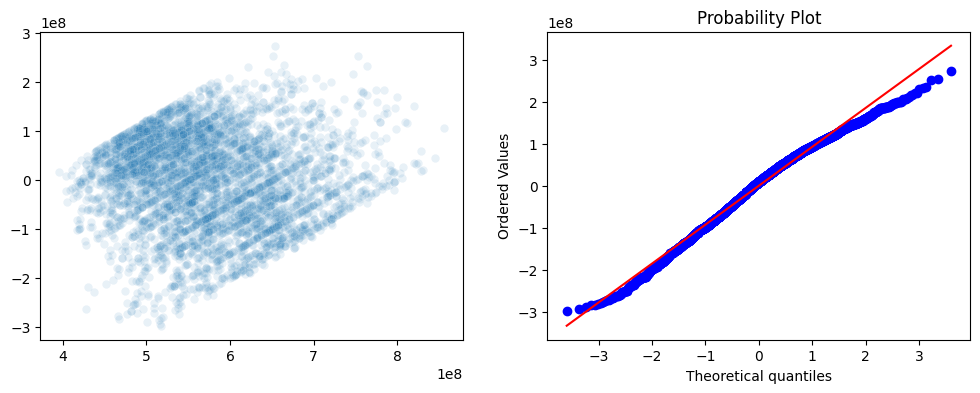

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[features2]), y=errors, alpha=0.1, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Se siguen teniendo mejoras en las métricas de error y se resuelve el problema de no normalidad de los errores.

<span style="color: red;">Desde el punto de vista de la estadística clásica esto está bien, pero también se debe preguntar: Si los puntos removidos son atípicas pero reales, es decir no obedecen a un problema en los datos, ¿qué decisión debería tomar el modelo en estos casos? ¿Cómo construir un modelo que sea más robusto a valores atípicos?</span>

### 7.4 Varianza constante (Homocedasticidad)

La varianza en los errores debe mantenerse constante a medida que varia la variable objetivo.


<Axes: >

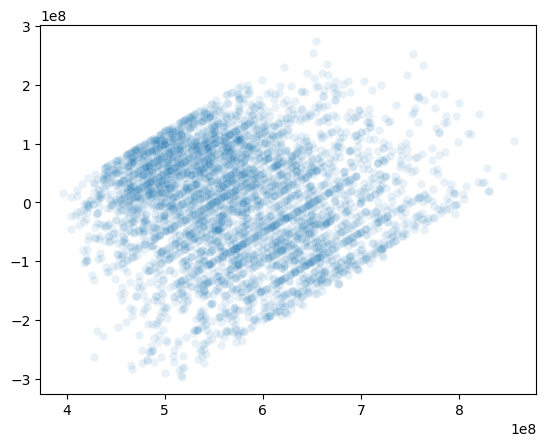

In [ ]:
sns.scatterplot(x = pipeline.predict(X_train[features2]), y=errors, alpha=0.1)

Este problema podría resolverse aplicando nuevamente transformaciones no lineales sobre las variables de entrada. Por otro lado, también puede indicar que hacen falta variables de entrada que ayuden a representar apropiadamente la variable objetivo.

## 8. Persistencia del modelo

Una vez que el modelo está listo, ¿cómo ponerlo en producción para que realice estimaciones para datos futuos?

Se debe empezar por persistir el modelo a un archivo binario para que posteriormente pueda ser reutilizado desde cualquier script o servicio.

In [ ]:
filename = "model.joblib"

In [ ]:
dump(pipeline, filename)

['model.joblib']

In [ ]:
pipeline_loaded = load(filename)